In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import torch

from discrete_manufacturing_sim.multi_linear_petri_net import MultiLinearPetriNet
from discrete_manufacturing_sim.dg.wdg import WeightedDirectedGraph
from discrete_manufacturing_sim.fsm.production_asset_fsm import ProductionAssetFSM
from discrete_manufacturing_sim.simulation_handler import SimulationHandler
# from discrete_manufacturing_sim.multi_temporal_event_handler import MultiTemporalEventHandler
from discrete_manufacturing_sim.generators.dg_generator import DGGenerator
from discrete_manufacturing_sim.generators.distribution_data_generator import DistributionDataGenerator
from discrete_manufacturing_sim.generators.multi_distribution_sampler import MultiDistributionSampler
from discrete_manufacturing_sim.multi_temporal_event_handler import MultiTemporalEventHandler

(600, 5)
(600, 5)
tensor([[0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0]], dtype=torch.int32)


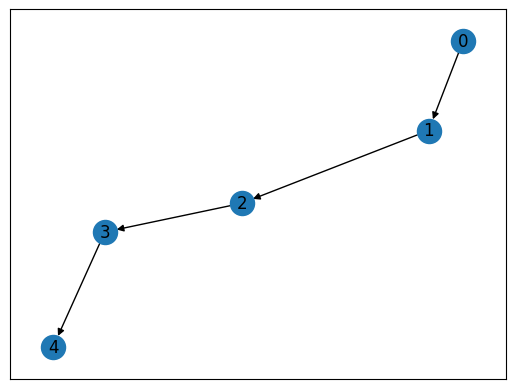

In [14]:
import matplotlib.pyplot as plt
import numpy as np

num_nodes = 5
length_pns = 2
batch_size = 100

adj_gen = DGGenerator(num_nodes=num_nodes)

adjacency_matrix = adj_gen.generate_linear_dag()

G = nx.from_numpy_matrix(adjacency_matrix.numpy(), create_using=nx.DiGraph)

pos = nx.spring_layout(G)  # Positions for all nodes

nx.draw_networkx(G, pos, with_labels=True, arrows=True)

means = torch.zeros(num_nodes, 3)
means[:, 0] = 180
means[:, 1] = 180 * 100
means[:, 2] = 180 * 20

results = []
results_state = []
time = []

for i in range(1):  # 10 runs
    # Multi Petri Net
    connectivity_graph = WeightedDirectedGraph(adjacency_matrix)
    multi_lin_pn = MultiLinearPetriNet(
        length_pns=length_pns, connectivity_graph=connectivity_graph)

    for i in range(num_nodes):
        multi_lin_pn.set_capacity(i, 1, 5)
    multi_lin_pn.set_capacity(num_nodes-1, 1, 1e10)

    # State Machine
    pfsm = ProductionAssetFSM()
    dist_gen = DistributionDataGenerator(means, distribution_types=['normal'], uniform_params={'spread': 0.1}, normal_params={'std_dev': 0.4})

    # Temporal Event Handling
    mds = MultiDistributionSampler(dist_gen)
    mteh = MultiTemporalEventHandler(mds)

    sim_handler = SimulationHandler(multi_lin_pn, pfsm, mteh)

    j = 0

    while sim_handler.multi_temp_event_handler.runtime < 8*3600:
        current_time = sim_handler.multi_temp_event_handler.runtime
        sim_handler.simulate()

        state_matrix = sim_handler.state_matrix.cpu().numpy()
        # Convert the last dimension to indices (0, 1, 2, 3)
        state_indices = np.argmax(state_matrix, axis=-1)

        # Detach markings tensor and append to results in batches
        if j % batch_size == 0:
            results_batch = np.zeros((batch_size, num_nodes))
            results_state_batch = np.zeros((batch_size, num_nodes))
            results.append(results_batch)
            results_state.append(results_state_batch)
        results[-1][j % batch_size] = sim_handler.mlin_pn.markings[:, 1].detach().cpu()
        results_state[-1][j % batch_size] = state_indices
        time.append(current_time)
        j += 1

# Concatenate batches to form the final results array
results = np.concatenate(results, axis=0)
results_state = np.concatenate(results_state, axis=0)

print(results.shape)
print(results_state.shape)

print(adjacency_matrix)


21.0


AttributeError: 'Axes' object has no attribute 'yticks'

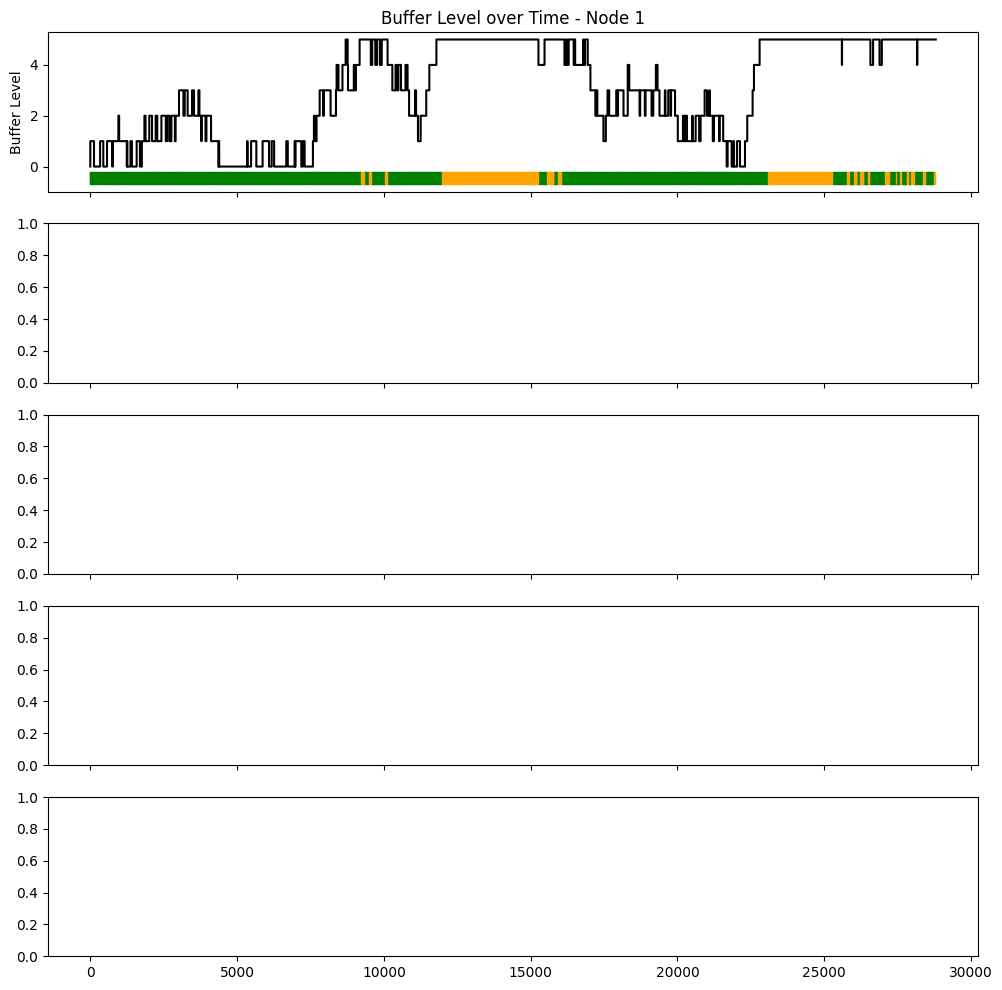

In [15]:
import matplotlib.pyplot as plt
import numpy as np

max_produced = np.max(results[:len(time), -1])
scaling = max_produced / 5 
print(scaling)

# Create figure and axes
fig, axs = plt.subplots(5, 1, figsize=(12, 12), sharex=True)

# Define colors for state values
state_colors = ['yellow', 'green', 'orange', 'red']
state_labels = ['$q_0$ : Idle', '$q_1$ : Producing', '$q_2$ : Blocked', '$q_3$ : Failed']

for i in range(num_nodes):
    # Plot state with colored areas
    for j in range(4):
        color = state_colors[j]
        state = results_state[:len(time), i]
        state_indices = np.where(state == j)[0]  # Get indices where state equals j
        for idx in range(len(state_indices)-1):
            start = time[state_indices[idx]]
            end = time[state_indices[idx] + 1]
            if i == (num_nodes - 1):
                axs[i].fill_between([start, end], -0.2 * scaling, -0.7 * scaling, color=color)
            else:
                axs[i].fill_between([start, end], -0.2, -0.7, color=color)

    # Plot markings
    axs[i].step(time, results[:len(time), i], color='black', label=f"Marking Node {i+1}")
    axs[i].set_ylabel("Buffer Level")
    

    if i == num_nodes - 1:  # Adjust y-axis limit for the last plot
        axs[i].set_ylim(-scaling, max_produced + 1)
        axs[i].set_title(f"Total Produced at - Node {i+1}")
    else:
        axs[i].set_title(f"Buffer Level over Time - Node {i+1}")
        axs[i].set_yticks(np.arange(0, 6, 1.0))

    # Add grid
    axs[i].grid(True)

# Set common x-axis label
fig.text(0.5, 0.0, 'Runtime $s$', ha='center')

# Add legend for states
handles, labels = [], []
for j in range(4):
    handles.append(plt.Rectangle((0, 0), 1, 1, fc=state_colors[j]))
    labels.append(state_labels[j])
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.15))

# Adjust layout and display plot
plt.tight_layout()
plt.show()

In [99]:

# Define colors for state values
state_colors = ['yellow', 'green', 'orange', 'red']

for i in range(num_nodes):
    # Plot markings and overlay state
    for j in range(4):
        color = state_colors[j]
        state = results_state[:len(time), i]
        state_indices = np.where(state == j)[0]  # Get indices where state equals j
        for idx in range(len(state_indices)-1):
            start = time[state_indices[idx]]
            end = time[state_indices[idx] + 1] if state_indices[idx] + 1 < len(time) else time[-1]
            axs[i].fill_between([start, end], 0, 1, color=color)
        if len(state_indices) > 0:
            # Fill the remaining space if the last state value is not 0
            if state[-1] == j:
                axs[i].fill_between([time[state_indices[-1]], time[-1]], 0, 1, color=color)
    axs[i].plot(time, results[:len(time), i], color='black', label=f"Marking Node {i+1}")
    axs[i].set_ylim(0, 1)
    axs[i].set_ylabel("Marking/State")
    axs[i].set_title(f"Marking and State over Time - Node {i+1}")

# Set common x-axis label
fig.text(0.5, 0.04, 'Time', ha='center')

# Adjust layout and display plot
plt.tight_layout()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'fill_between'